LeNet Implementation

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython import display
# import external libraries if not present so putting inside try except
try:
  import torch
except ModuleNotFoundError:
  %pip install -qq torch
  import torch
try:
  import torchvision
except ModuleNotFoundError:
  %pip install -qq torchvision
  import torchvision

from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms

import random
import os
import time

np.random.seed(seed=1)
torch.manual_seed(1)
# to save figures
!mkdir figures



mkdir: figures: File exists


# Building the model
Layering :
1. Input : Input size 28x28
2. Convolution : Mnist dataset is a grayscale image so channels = 1. We break it into 6 channels with kernel size 5 and padding 2 which uses the same size image output with 6 channels as we know 2*padding = kernel_size - 1  : (5-1)/2
3. Pooling : Here we take 6 channel image and pass it through the AvgPooling layer which makes this of 14x14 size (we know **`(height_of_image + 2_padding_height - filter_kernel_height + stride_height)/stride_height`** is the output size)



In [13]:
from torch.nn.modules.activation import Sigmoid
class Reshape(torch.nn.Module):
  def forward(self,x):
    return x.view(-1,1,28,28)

net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5, padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84, 10),
)

# print all the layers and checks for compilation errors in the model
X = torch.rand(size=(1,1,28,28), dtype=torch.float32)
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, "output shape: \t", X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


# Data

In [14]:
def load_minist_dataset(batch_size, resize=None):
  """Download the fashion-MNIST dataset and then load it into memory"""
  trans = [transforms.ToTensor()]
  if resize:
    trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
  mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)
  return (
    data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4),
    data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=4)
  )

In [15]:
batch_size = 256
train_iter, test_iter = load_minist_dataset(batch_size=batch_size)
for _,y in train_iter:
    print(np.unique(y))
    break


[0 1 2 3 4 5 6 7 8 9]


In [16]:
class Animator:
  """For plotting data in animation"""

  def __init__(
      self,
      xlabel=None,
      ylabel=None,
      legend=None,
      xlim=None,
      ylim=None,
      xscale="linear",
      yscale="linear",
      fmts=("-", "m--", "g-", "r:"),
      nrows=1,
      ncols=1,
      figsize=(3.5, 2.5),
  ):
      #Incrementally plot multiple lines
      if legend is None:
          legend = []
      display.set_matplotlib_formats("svg")
      self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
      if nrows*ncols == 1:
        self.axes = [
            self.axes,
        ]
      #Use lamda function to capture arguments
      self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
      self.X, self.Y, self.fmts = None, None, fmts

  def add(self, x, y):
    # Add multiple data points into the figure
    if not hasattr(y, "__len__"):
      y = [y]
    n = len(y)
    if not hasattr(x, "__len__"):
      x = [x] * n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]

    for i ,(a,b) in enumerate(zip(x, y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x, y, fmt in zip(self.X, self.Y, self.fmts):
      self.axes[0].plot(x, y, fmt)
    self.config_axes()
    display.display(self.fig)
    display.clear_output(wait=True)

class Timer:
  """Record multiple running times."""
  def __init__(self):
    self.times = []
    self.start()

  def start(self):
    """Start the timer."""
    self.tik = time.time()

  def stop(self):
    """Stop the timer and record the time in a list."""
    self.times.append(time.time() - self.tik)
    return self.times[-1]

  def avg(self):
    """Returns the average time"""
    return sum(self.times) / len(self.times)

  def sum(self):
    """Returns the sum of time."""
    return sum(self.times)

  def cumsum(self):
    """Return the accumulated time."""
    return np.array(self.times).cumsum().tolist()

class Accumulator:
  """For accumulating sums over `n` variables."""

  def __init__(self, n):
    self.data = [0.0] * n

  def add(self, *args):
    self.data = [a + float(b) for a, b in zip(self.data, args)]

  def reset(self):
    self.data = [0.0] * len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [17]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
  """Set the axes for matlabplots."""
  axes.set_xlabel(xlabel)
  axes.set_ylabel(ylabel)
  axes.set_xlim(xlim)
  axes.set_ylim(ylim)
  axes.set_xscale(xscale)
  axes.set_yscale(yscale)
  if legend:
    axes.legend(legend)
  axes.grid()


In [18]:
def try_gpu(i=0):
  """Return gpu(i) if exists, otherwise return cpu()."""
  if torch.cuda.device_count() >= i+1:
    return torch.device(f"cuda:{i}")
  return torch.device("cpu")

In [19]:
# We compute classification accuracy on the current batch
# and add this metric to the accumulator, for plotting purposes

def accuracy(y_hat, y):
  """Compute the number of correct predictions."""
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = torch.argmax(y_hat, axis=1)
  cmp_ = y_hat.type(y.dtype) == y
  return float(cmp_.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
  """Compute the accuracy of the model on the dataset using GPU"""
  if isinstance(net, torch.nn.Module):
    net.eval() # Set the model to evaluation mode
    if not device:
      device = next(iter(net.parameters())).device
  # No. of correct predictions, no. of predictions
  metric = Accumulator(2)
  for X, y in data_iter:
    X = X.to(device)
    y = y.to(device)
    metric.add(accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]


# Training function

Training loop is a standard one. Uses accumulator to make a 3d plot over time

In [20]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)

  net.apply(init_weights)
  print("training on", device)
  net.to(device)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()
  animator = Animator(xlabel="epoch",xlim=[1, num_epochs], legend = ["train loss","train acc", "test acc"])
  timer, num_batches = Timer(), len(train_iter)
  for epoch in range(num_epochs):
    # Sum of training loss, sum of training accuracy, no of examples
    metric = Accumulator(3)
    net.train()
    for i, (X,y) in enumerate(train_iter):
      timer.start()
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      print(y_hat.shape)
      print(y.shape)
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
      timer.stop()
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))
  print(f"loss {train_l:.3f}, train_acc:{train_acc:.3f}, " f"test acc {test_acc:.3f}")
  print(f"{metric[2] * num_epochs / timer.sum():.1f} examples/sec " f"on {str(device)}")

training on cpu


/var/folders/75/_0h54l8n6ys6k7klg1v8zggh0000gn/T/ipykernel_2125/1201685167.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])
torch.Size([256, 10])
torch.Size([256])


KeyboardInterrupt: 

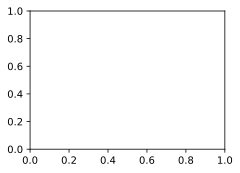

In [21]:
lr, num_epochs = 0.9, 10
train(net, train_iter, test_iter, num_epochs, lr, try_gpu())